In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [26]:
def rmsle(actual, predicted):
    error = np.log1p(predicted) - np.log1p(actual)
    return np.sqrt(np.mean(np.square(error)))

In [9]:
train_set = pd.read_csv('../train_set_ym.csv')

In [10]:
train_set.dtypes

tube_assembly_id       object
supplier               object
annual_usage            int64
min_order_quantity      int64
bracket_pricing        object
quantity                int64
cost                  float64
year                    int64
month                   int64
dtype: object

In [305]:
model_data = train_set[train_set.bracket_pricing == 'No']

In [306]:
model_data = model_data.drop(['bracket_pricing'], axis=1)

In [289]:
model_data = pd.get_dummies(model_data, columns=['supplier'])

In [307]:
tube = pd.read_csv('../tube_material_id_imputed_dummies_drop_ns.csv')

In [308]:
comp_weight = pd.read_csv('../comp_weight.csv')

In [309]:
# model_data = pd.merge(model_data, tube, how='left', on='tube_assembly_id')
model_data = pd.merge(model_data, comp_weight, how='left', on='tube_assembly_id')

In [310]:
print model_data.shape
model_data.head()

(3930, 9)


,tube_assembly_id,supplier,annual_usage,min_order_quantity,quantity,cost,year,month,weight
0,TA-00013,S-0026,50,1,1,10.004284,1992,7,0.215
1,TA-00021,S-0030,1,1,1,3.433061,2014,2,0.052
2,TA-00022,S-0013,1,1,1,8.563178,2011,7,0.018
3,TA-00027,S-0062,30,1,1,2.737546,1993,9,0.028
4,TA-00037,S-0062,600,1,1,1.563517,1994,9,0.024


In [224]:
import sklearn.cross_validation as skcv
import sklearn.ensemble as sken
import sklearn.grid_search as skgs

In [311]:
model_train, model_test = skcv.train_test_split(model_data, random_state=5, train_size=0.7)

In [283]:
# skcv.KFold()

In [312]:
print model_train.shape
print model_test.shape

(2751, 9)
(1179, 9)


In [295]:
rf = sken.RandomForestRegressor(n_estimators=100, max_features=5)
# rf = sken.ExtraTreesRegressor(n_estimators=50)
# rf = sken.GradientBoostingRegressor(learning_rate=0.25, n_estimators=200)

In [313]:
model_train_X = model_train.drop(['tube_assembly_id', 'cost'], axis=1)
rf = rf.fit(model_train_X, np.log1p(model_train.cost))

ValueError: could not convert string to float: S-0013

In [297]:
model_train_pred = np.expm1(rf.predict(model_train_X))
print rmsle(model_train.cost, model_train_pred)

0.215507346458


In [298]:
model_train_actual_fit = pd.DataFrame({'actual' : log1p(model_train.cost), 'fit' : log1p(model_train_pred)})

In [299]:
model_feature_importance = pd.DataFrame({'feature' : model_train_X.columns, 'score' : rf.feature_importances_})

In [304]:
model_feature_importance

,feature,score
0,annual_usage,0.217973
1,min_order_quantity,0.066302
2,quantity,0.051963
3,year,0.077305
4,month,0.068600
5,supplier_S-0003,0.001244
6,supplier_S-0004,0.000085
7,supplier_S-0005,0.001694
8,supplier_S-0006,0.000186
9,supplier_S-0007,0.001097


In [300]:
important_feats = model_feature_importance.sort(columns=['score'], ascending=False).head(12).feature.values

In [303]:
important_feats

array(['weight', 'annual_usage', 'supplier_S-0066', 'year', 'month',
       'min_order_quantity', 'quantity', 'supplier_S-0041',
       'supplier_S-0026', 'supplier_S-0072', 'supplier_S-0013',
       'supplier_S-0030'], dtype=object)

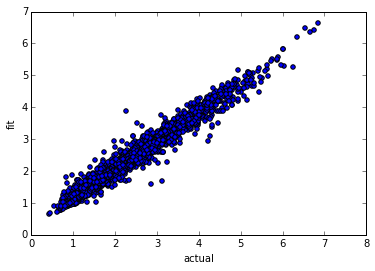

In [301]:
model_train_actual_fit.plot(x='actual', y='fit', kind='scatter')
plt.show()

In [302]:
model_test_X = model_test.drop(['tube_assembly_id', 'cost'], axis=1)
model_test_pred = np.expm1(rf.predict(model_test_X))
print rmsle(model_test.cost, model_test_pred)

0.533998807167


In [268]:
model_test_actual_fit = pd.DataFrame({'actual' : log1p(model_test.cost), 'fit' : log1p(model_test_pred)})

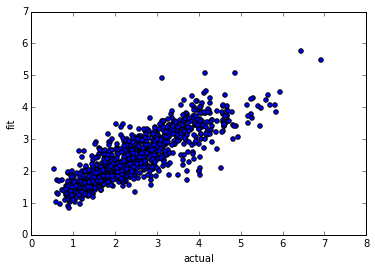

In [269]:
model_test_actual_fit.plot(x='actual', y='fit', kind='scatter')
plt.show()

In [270]:
model_train_X_imps = model_train[important_feats]
rf = rf.fit(model_train_X_imps, np.log1p(model_train.cost))

In [271]:
model_train_imps_pred = np.expm1(rf.predict(model_train_X_imps))
print rmsle(model_train.cost, model_train_imps_pred)

0.202504420185


In [272]:
model_test_X = model_test.drop(['tube_assembly_id', 'cost'], axis=1)
model_test_X_imps = model_test_X[important_feats]
model_test_pred = np.expm1(rf.predict(model_test_X_imps))
print rmsle(model_test.cost, model_test_pred)

0.53914474706


In [273]:
rf = sken.RandomForestRegressor(n_estimators=100, max_features=5, random_state=0)
gridcv = skgs.GridSearchCV(rf, param_grid={'n_estimators' : [50, 100, 200, 500]})

In [274]:
gridcv.fit(model_train_X, log1p(model_train.cost))

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [275]:
gridcv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [276]:
model_train_pred = expm1(gridcv.predict(model_train_X))
print rmsle(model_train.cost, model_train_pred)

0.196731086559


In [277]:
model_test_X = model_test.drop(['tube_assembly_id', 'cost'], axis=1)
model_test_pred = expm1(gridcv.predict(model_test_X))
print rmsle(model_test.cost, model_test_pred)

0.532419121412
